# **Has Pop Music Gotten Sadder over the Past 10 Years?**

## Will Young and Rainier Hardjanto

**Research Question**

 Americans are getting sadder. Ten years ago, a yearly Gallup poll ranked the US as the 11th happiest country. This year, they were ranked 23rd. Senator Chris Murphy recently told Congress "over the last 10 years the rate of happiness, of contentment, of fulfillment, self-reported by Americans, is dropping". This brings up the interesting question of whether the music we listen to has gotten sadder with us, which led us to our research question: "Has Pop Music Gotten Sadder over the Past 10 Years?". There is not a clear instinctual answer to this question: one could speculate that we turn to music to escape from our reality, which would mean that our music would get happier as we get sadder, but it is also plausible that we want to relate to music more than we want to use it to escape, which would lead to our music getting sadder with us. In order to investigate this question, we will be performing sentiment analysis on the lyrics of the most popular songs from 2013-2023.

**Methodology**

The data that we used to address our research question is the lyrics from every song on the year-end Billboard Hot 100 chart for every year from 2013 through 2023. This data was pulled from the Genius website (https://genius.com/), an online music encyclopedia that contains lyrics to millions of songs.

To scrape this data, we first imported our libraries; Pandas was used to help organize our scraped data and the LyricsGenius library was used to simplify the process of making requests through Genius's API. We also imported our helper function file and our API key. 

In [6]:
from lyricsgenius import Genius
import helper_function
import api_key  # You'll have to make one of these yourself on the Genius website

genius = Genius(api_key.client_access_token)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/wyoung/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


We then loaded and formatted our initial data. In this case, our initial data was a database of the title, artist, year, and chart position for every song we were planning to scrape.

In [5]:
# Load and format billboard data
billboard_df = pd.read_csv("billboard_100.csv")
artists = helper_function.generate(billboard_df)
artists_series = pd.Series(artists)
lyrics = []

Once our data was loaded, we were ready to begin scraping songs. This process took quite a long time (multiple hours). Once the process was complete, the lyrics were added to our original data and the completed dataset was saved to a file. 

In [ ]:
# Number of songs to be scraped. If scraping all songs, should be 1100
NUM_SONGS = 1100

# Scrape the songs
for i in range(NUM_SONGS):
    while True:
        try:
            song = genius.search_song(
                billboard_df["Title"][i], artists_series[i]
            )
            break
        except:  # If the request times out (which often happens), request again
            pass
    lyrics.append(helper_function.format_genius_lyrics(song.lyrics))

# Save the scraped data into a DataFrame
df = pd.DataFrame(
    {
        "No.": billboard_df["No."][:NUM_SONGS],
        "Title": billboard_df["Title"][:NUM_SONGS],
        "Artists": artists_series[:NUM_SONGS],
        "Year": billboard_df["Year"][:NUM_SONGS],
        "Lyrics": pd.Series(lyrics),
    }
)

# Save the data to a file
df.to_csv("billboard_data_with_lyrics", encoding="utf-8", index=False)

In order to use this data to answer the research question, we need to understand the emotions present in the lyrics. Determining these emotions will allow us to examine the trends of said emotions over time, from which we can see whether there are trends toward sadder lyrics. In order to determine these emotions, we processed the lyrics we scraped using NLTK's VADER. VADER, which stands for "Valence Aware Dictionary and sEntiment Reasoner" is a lexicon and rule-based sentiment analysis tool that rates the sentiment of a passage of text from -1 to 1, where -1 is extremely negative sentiment and 1 is extremely positive sentiment. We specifically selected VADER as our sentiment analysis tool because in addition to being the highest rated rule-based sentiment analysis tool, it is especially good at understanding slang, which is extremely common in pop music.

The primary way that we processed this data was by finding the sentiment score for every song we scraped. We then added this data to the dataframe that we previously saved to the file, and used this dataframe to build our first visualization.

In [7]:
%matplotlib
import csv
import re
import cv2
import nltk
import mplcursors  # separate package must be installed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from matplotlib.patheffects import withSimplePatchShadow
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")  # Run this line the first time you run this code

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Import data
loaded_data = pd.read_csv("billboard_data_with_lyrics")
lyrics_data = loaded_data["Lyrics"]

# FIRST VISUALIZATION - Polarity of Every Top Song with Trendline
positivity_scores = []

# Add a Positivity series to the Billboard dataframe
for i in range(len(lyrics_data)):
    positivity_scores.append(
        analyzer.polarity_scores(lyrics_data[i])["compound"]
    )

all_data = pd.concat(
    [loaded_data, pd.DataFrame({"Positivity": positivity_scores})], axis=1
)

Using matplotlib backend: TkAgg


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/wyoung/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


The second way we processed our data was by finding the top 5 artists for every year based on a ranking algorithm we created. This algorithm gave a relative weight to each position on the chart, and summed the weights of each artist's songs to determine the top artists. We then took those artists and found the average polarity of all their Top 100 songs from that year, which we used to create our second and third visualizations.

In [11]:
top_artist_polarityscore = []

with open("billboard_data_with_lyrics.csv", mode="r", encoding="utf-8") as file:
    # Create a CSV reader
    csv_reader = csv.reader(file)

    # Convert it to a list to get the ability to use len() and indexing
    rows = list(csv_reader)

    # Iterate using indices
    for j in range(11):
        scores_by_artist = {}
        for i in range(100):
            score = 101 - i  # Calculate the score based on ranking
            artist = rows[j * 100 + i][2]
            if artist in scores_by_artist:
                scores_by_artist[artist] += score
            else:
                scores_by_artist[artist] = score
        # Step 2 & 3: Sort Artists by Total Score
        sorted_artists = sorted(
            scores_by_artist.items(), key=lambda x: x[1], reverse=True
        )

        # Step 4: Select the Top 5 Artists
        top_5_artists = sorted_artists[:5]
        top_5_artist_names = [artist[0] for artist in top_5_artists]

        polarity_score = {}
        polarity_count = {}
        for i in range(100):
            artist = rows[j * 100 + i][2]

            if (artist in top_5_artist_names) is False:
                continue

            if artist in polarity_score:
                polarity_score[artist] += helper_function.polarity(
                    rows[j * 100 + i][4]
                )["compound"]
                polarity_count[artist] += 1
            else:
                polarity_score[artist] = helper_function.polarity(
                    rows[j * 100 + i][4]
                )["compound"]
                polarity_count[artist] = 1

        for x, y in polarity_score.items():
            polarity_score[x] /= polarity_count[x]
        top_artist_polarityscore.append(polarity_score)

extended_data = top_artist_polarityscore

The third way we processed our data was by creating dictionaries of all the negative words (based on their VADER sentiment score) and the amount of times they appear in the lyrics as a whole. We created three dictionaries - one from 2013 to 2016, one from 2017 to 2020, and one from 2021 to 2023 - to investigate how the languaged used to describe sadness and negativity changed over time, and used these to create our fourth visualization.

In [8]:
CSV_FILE_PATH = "billboard_data_with_lyrics.csv"

# List of words that are not very interesting, don't have interesting changes,
# and reduce the effectiveness of the word cloud visual
irrelevant_words = [
    "fuck",
    "bitch",
    "bitches",
    "dick",
    "niggas",
    "shit",
    "fucked",
    "bad",
    "damn",
    "ass",
    "fire",
]

with open(CSV_FILE_PATH, encoding="utf8", newline="") as csvfile:
    csvreader = csv.reader(csvfile)

    words_dictionary = {}
    words_dictionary1 = {}
    words_dictionary2 = {}
    list_of_dictionary = [
        words_dictionary,
        words_dictionary1,
        words_dictionary2,
    ]

    for count, row in enumerate(csvreader, start=0):
        words = helper_function.split_text_into_words(row[4])
        for word in words:
            word = (
                word.lower()
            )  # Ensure upper/lower case does not affect visual
            if word in irrelevant_words:
                continue
            if helper_function.polarity(word)["compound"] < -0.3:
                # Choose the correct dictionary based on the count
                current_dict = list_of_dictionary[count // 400]
                # Use get to avoid KeyError, defaults to 0 if the key doesn't
                # exist
                current_dict[word] = current_dict.get(word, 0) + 1

**Results**

Now that we have processed all our data, we can go ahead and plot our visualizations.


In [14]:
%matplotlib
# FIRST VISUALIZATION - Polarity of Every Top Song with Trendline

# Plot average positivity scores for each year from the past 10 years
scores = [
    sum(positivity_scores[:101]) / 100,
    sum(positivity_scores[100:201]) / 100,
    sum(positivity_scores[200:301]) / 100,
    sum(positivity_scores[300:401]) / 100,
    sum(positivity_scores[400:501]) / 100,
    sum(positivity_scores[500:601]) / 100,
    sum(positivity_scores[600:701]) / 100,
    sum(positivity_scores[700:801]) / 100,
    sum(positivity_scores[800:901]) / 100,
    sum(positivity_scores[900:1001]) / 100,
    sum(positivity_scores[1000:1101]) / 100,
]
years = [
    2013.5,
    2014.5,
    2015.5,
    2016.5,
    2017.5,
    2018.5,
    2019.5,
    2020.5,
    2021.5,
    2022.5,
    2023.5,
]  # add .5 to all years to make visualization more effective

plt.figure()
plt.plot(years, scores, "r--")  # plot general trend line
plt.xlabel("Year")
plt.ylabel("Polarity Score")
plt.title("Polarity Score of Every Top 100 Song, 2013-2023")
# Plot every song and its score
indiv_scores = plt.scatter(
    np.linspace(2013, 2023.99, num=1100), positivity_scores
)


# Using the mplcursors library, display information about each data point
# when you hover over it.
def show_hover_panel(get_text_func=None):
    """
    Displays specified content whenever the cursor is hovering over a data
    point.

    Args:
        get_text_func: A string that contains text to be displayed. If it is
        None, no box will be displayed.

    Returns:
        a cursor object that displays a box contanining specified content
        whenever it hovers over a data point.
    """
    cursor = mplcursors.cursor(
        hover=2,  # Transient
        annotation_kwargs=dict(
            bbox=dict(
                boxstyle="square,pad=0.5",
                facecolor="white",
                edgecolor="#ddd",
                linewidth=0.5,
                path_effects=[withSimplePatchShadow(offset=(1.5, -1.5))],
            ),
            linespacing=1.5,
            arrowprops=None,
        ),
        highlight=True,
        highlight_kwargs={"linewidth": 2},
    )

    if get_text_func:
        cursor.connect(
            event="add",
            func=lambda sel: sel.annotation.set_text(get_text_func(sel.index)),
        )
    return cursor


def on_add(index):
    """
    Returns the text that should be displayed when the cursor is hovering over a
    specific data point.
    Args:
        index: an integer representing the index of the current data point in
        the dataset
        dataframe: the dataframe for the data being displayed.
    Returns:
        A string containing the text to be displayed when the specific data
        point is hovered over.
    """
    try:
        parts = [
            f"Song: {all_data['Title'][index]}",
            f"Artist: {all_data['Artists'][index]}",
            f"Chart Position: {all_data['No.'][index]}",
            f"Score: {all_data['Positivity'][index]}",
        ]
        return "\n".join(parts)
    except KeyError:  # don't hover when the cursor is over the trendline
        return None


show_hover_panel(on_add)  # add hover labels
plt.show()

/home/wyoung/anaconda3/lib/python3.11/site-packages/mplcursors/_mplcursors.py:422: UserWarning: Glyph 9 (	) missing from current font.
  bbox = ann.get_window_extent(renderer)
/home/wyoung/anaconda3/lib/python3.11/tkinter/__init__.py:861: UserWarning: Glyph 9 (	) missing from current font.
  func(*args)


From our first visualization, we can see some very interesting trends. First of all, the overall trend of the average polarity is slightly negative, which would suggest that pop music is getting slightly sadder. However, the correlation for this downward trend is somewhat weak and the decrease is fairly gradual, so it would be a stretch to conclude from this alone that pop music has gotten sadder. Another interesting trend we can see is that the absolute polarity of pop songs have increased, as the middle third of the right end of the graph is very hollowed out, which suggests that sad songs have gotten sadder, and happier songs have gotten happier.

We can now move to our second visualization and take a closer look at the top five artists.

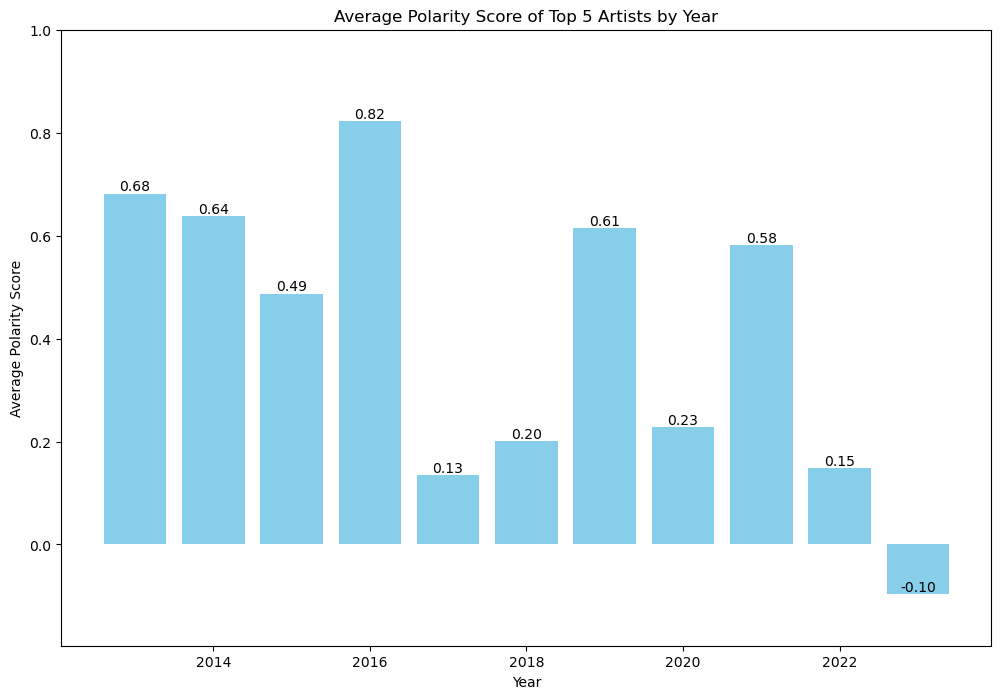

In [30]:
%matplotlib inline
# SECOND VISUALIZATION - Average Polarity Score of Top 5 Artists by Year

# Calculate the range of years
years = np.arange(2013, 2013 + len(top_artist_polarityscore))

# Calculate the average polarity score for each year
average_scores = [
    np.mean(list(year.values())) for year in top_artist_polarityscore
]

# Set up the plot
plt.figure(figsize=(12, 8))

# Create a bar chart
plt.bar(years, average_scores, color="skyblue")

# Make sure the Y-axis starts below zero if there are negative values
plt.ylim([min(average_scores) - 0.1, 1])

# Labeling
plt.title("Average Polarity Score of Top 5 Artists by Year")
plt.xlabel("Year")
plt.ylabel("Average Polarity Score")

# Add value labels on each bar
for i, score in enumerate(average_scores):
    plt.text(years[i], score, f"{score:.2f}", ha="center", va="bottom")

# Show the plot
plt.show()


From the above visualization, we can see that the slight downward trend we saw across all songs is amplified when we only look at the top artists, which strengthens our theory that pop music as a whole has gotten slightly sadder. We can also see that the positivity was always pretty high until 2016, and then became much more volatile in the years following. This suggests that there may have potentially been a shift in the genre between 2016 and 2017 that may have caused this drop.

We can now move on to our third visual, and examine each individual artist further.

/tmp/ipykernel_222000/1441056481.py:37: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/home/wyoung/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


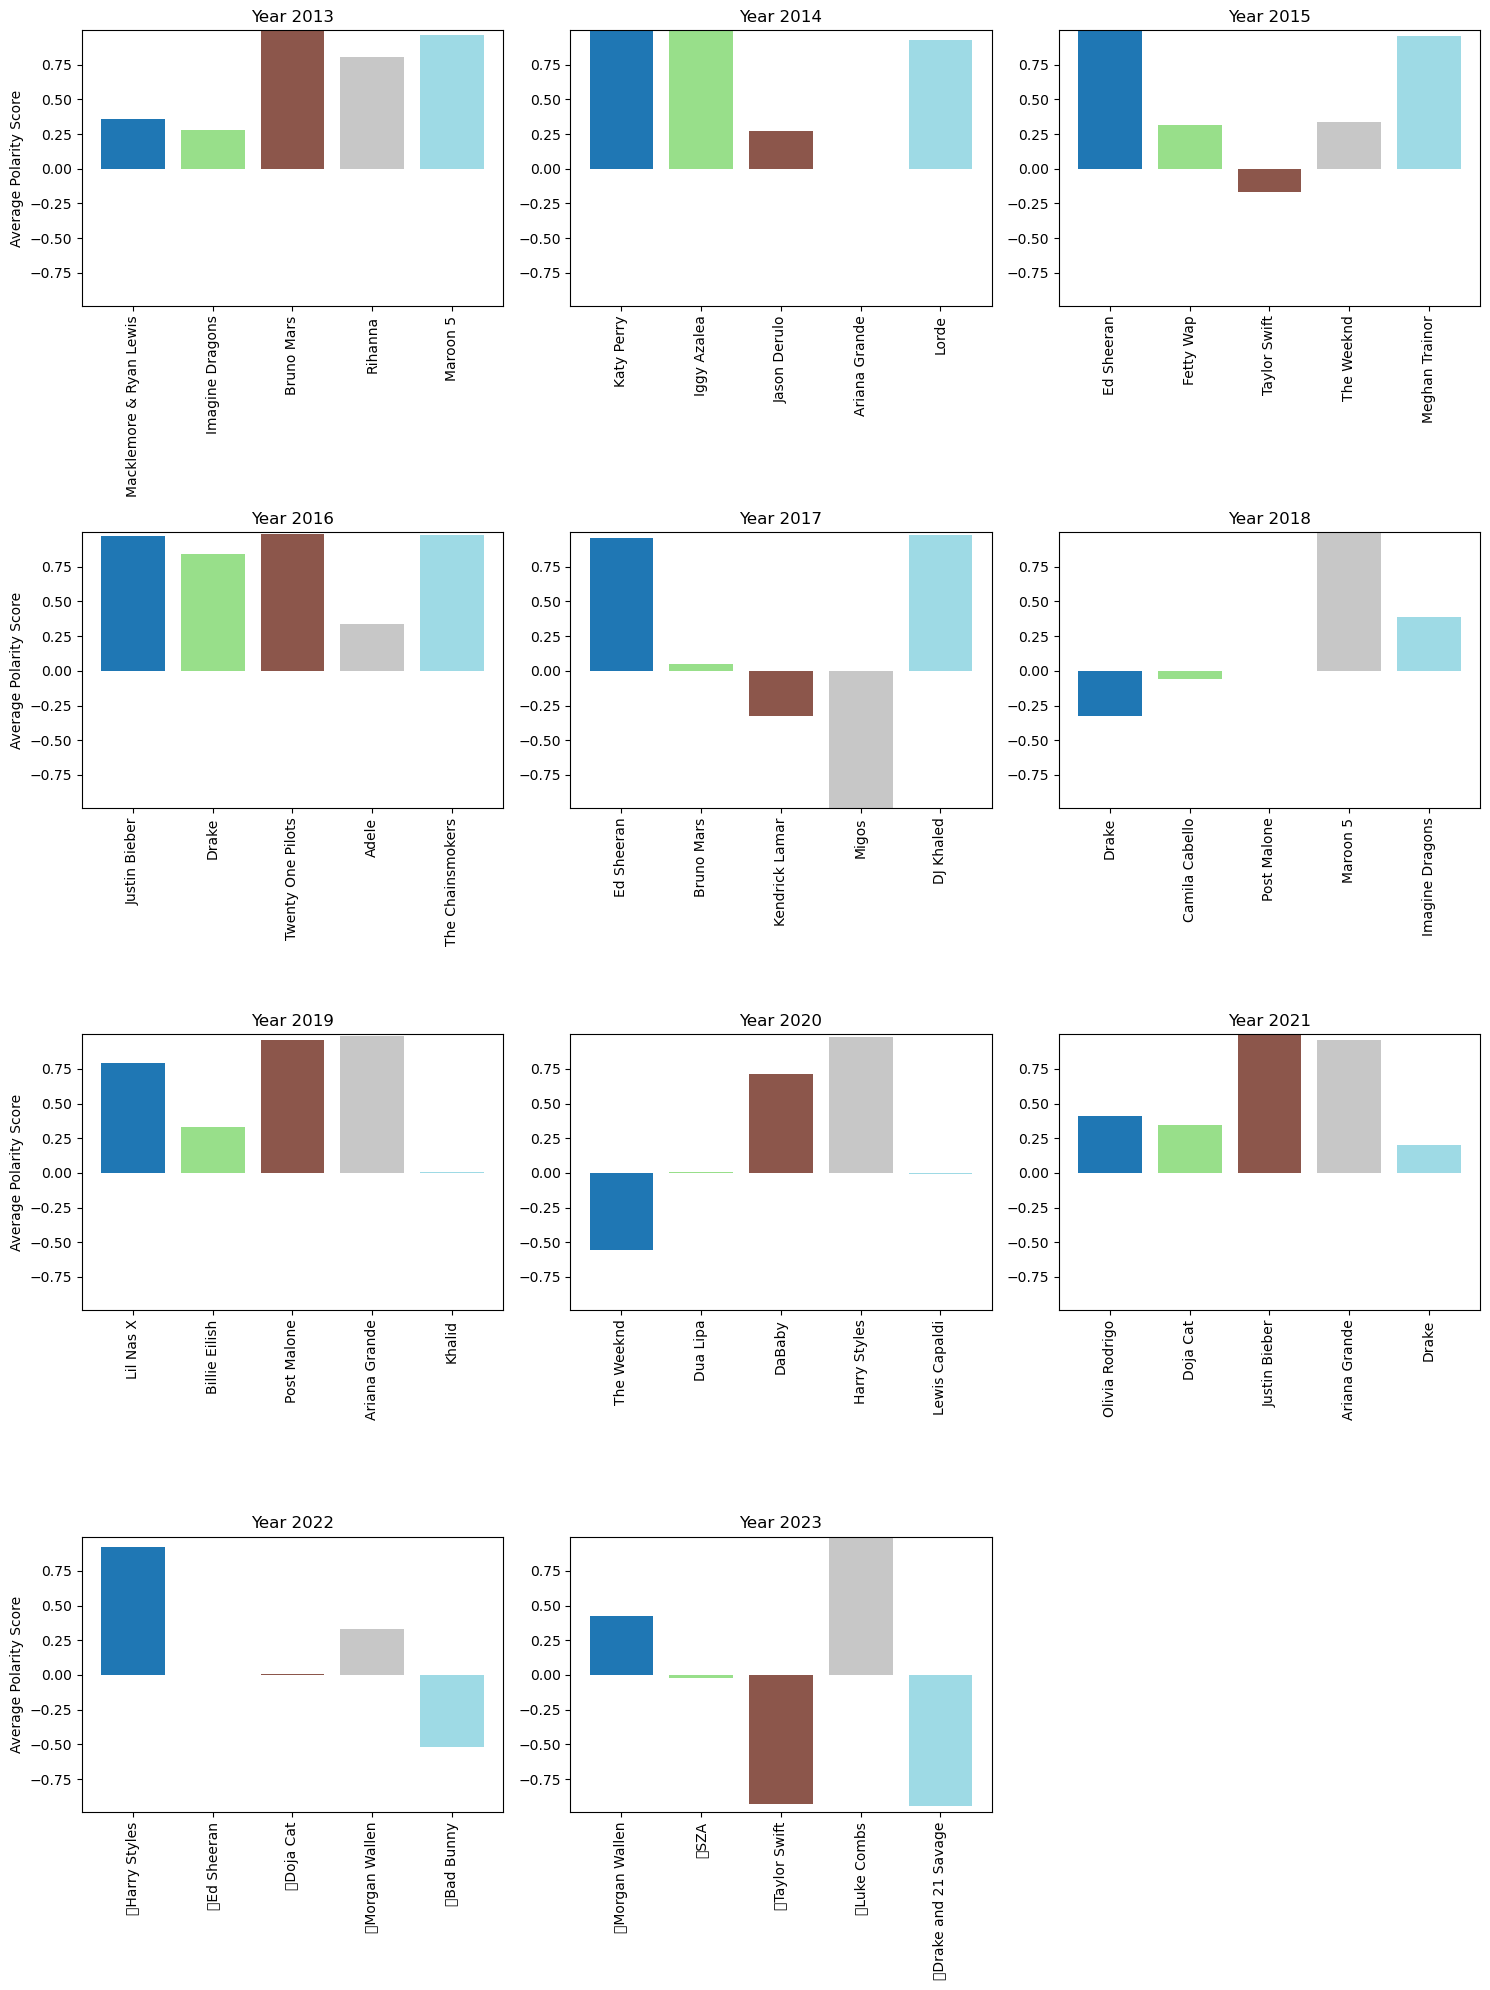

In [32]:
%matplotlib inline
# THIRD VISUALIZATION - Polarity Scores of Top 5 Artists from Every Year

# Determine global min and max polarity scores for consistent y-axis limits
all_scores = [
    score for yearly_data in extended_data for score in yearly_data.values()
]
global_min = min(all_scores)
global_max = max(all_scores)
NCOLS = 3
NROWS = len(top_artist_polarityscore) // NCOLS + (
    len(top_artist_polarityscore) % NCOLS > 0
)

# Create a large figure to hold all subplots
plt.figure(figsize=(NCOLS * 5, NROWS * 5))  # Width and height of entire figure

for i, yearly_data in enumerate(extended_data, start=1):
    ax = plt.subplot(NROWS, NCOLS, i)
    artists = list(yearly_data.keys())
    scores = list(yearly_data.values())
    y_pos = np.arange(len(artists))

    ax.bar(y_pos, scores, color=plt.cm.tab20(np.linspace(0, 1, len(artists))))
    ax.set_xticks(y_pos)
    ax.set_xticklabels(artists, rotation=90)
    ax.set_title(f"Year {2013 + i - 1}")

    # Set the same y-axis limit for all subplots
    ax.set_ylim(global_min, global_max)

    # Set the y-axis label only for the leftmost subplots
    if i % NCOLS == 1:
        ax.set_ylabel("Average Polarity Score")

# Adjust the layout so labels and titles do not overlap
plt.tight_layout()

# Display the visualization
plt.show()

From our third visual, we can see that top artists with negative sentiment have become much more prevalent as time has gone on. Only one strongly negative artist (polarity < 0.5) occurred before 2020 (Migos in 2017), but since 2020 four strongly negative artists have made it into the top five. This suggests that our society has become more receptive to sadder songs as time has gone on, which supports the idea that we enjoy sadder songs when we can better relate to them.

We can now move on to our fourth visual, and look deeper into the negative language that is used in these songs.

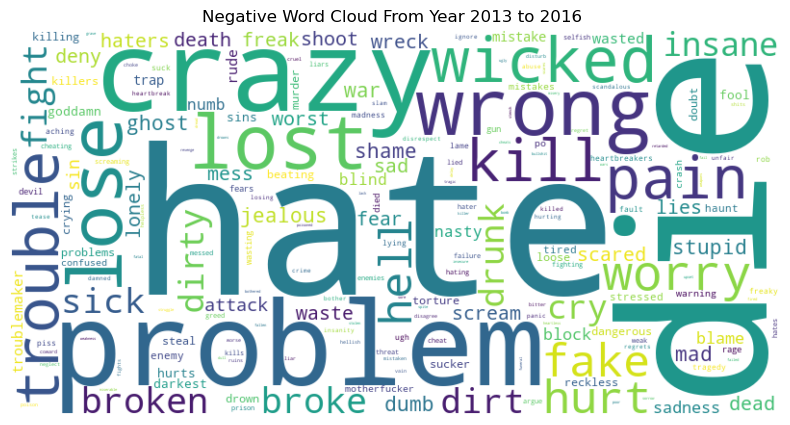

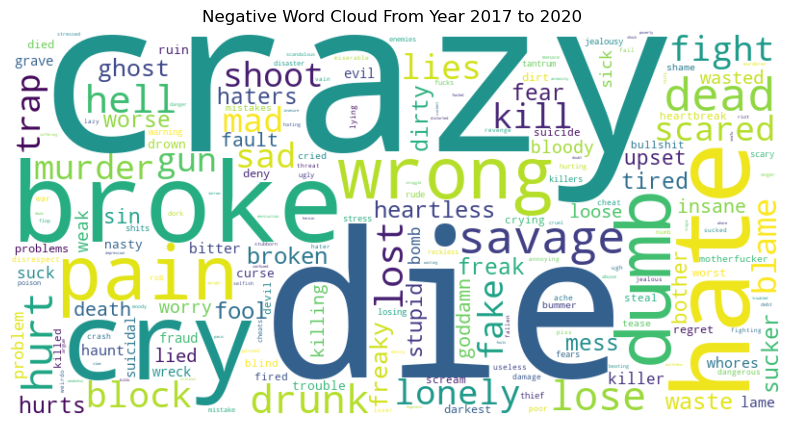

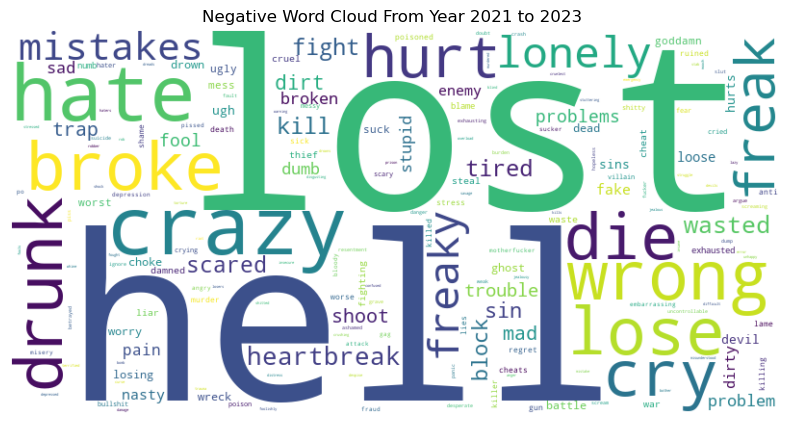

In [9]:
%matplotlib inline
# Generate the word clouds
YEAR = 2013
for i in range(3):
    helper_function.generate_word_cloud_from_frequencies(
        list_of_dictionary[i],
        f"Negative Word Cloud From Year {YEAR} to {YEAR + 3 - (i == 2)} ",
    )
    YEAR += 4


From our fourth visual, we can see that the negative language that is most prevalent has shifted significantly over time, and all three eras (2013-2016, 2017-2020, and 2021-2023) have very distinct word profiles. 

Looking at the word cloud from 2013-2016, we can see that the most common words are typically more "straightforwardly negative" words: "hate", "die", "problem", and "wrong" are all very significant. The word cloud from 2017 to 2020 tells a different story: "crazy", "cry", and "broke" are now much more significant, which seem more "sad" and less "negative". All of those words also describe more surface-level characteristics or realities, which give this era a sort of "surface-level sadness". The word cloud from 2021-2023 tells a third distinct story: the words "lost" and "hell" are now the most significant negative words. This represents a significant shift from the superficial descriptions of the 2017-2020 era into a sort of more internal "deeper sadness". Overall, these word clouds show that the way negativity and sadness are discussed lyrically in pop music has shifted significantly.

**Interpretation**

In the visualizations above, we have seen that pop music's average positivity score has decreased slightly and songs have become more strongly polarized, the positivity of the top artists has decreased significantly, the fact that strongly negative top artists have become more frequent in recent years, and the most common negative words used have shifted from "straightforwardly negative" to "surface-level sad" to "deeper sad". Though any one of these observations alone would not be significant enough to draw conclusions from, from all these findings together we can conclude that pop music has gotten sadder, from a lyrical perspective, over the past ten years. In addition, we can also speculate (but not justifiably conclude) that happier songs have gotten happier, which could suggest that those songs are used more to "escape" as we get sadder.

We learnt an important insight that different types of data depending on the type of data and the sample we use can convey different meanings. For example, in the word cloud, we observed that songs within the recent years have felt more fundamentally sad within a internal and personal level, describing features like being “lost”,which provided a much different perspective compared to our quantitative data. Hence we learnt the importance of using different types of data for analysis. We also learnt important lessons in using github, web scraping, and data analysis. We also learnt the important lesson of time management, and how that should be utilized when doing project work.  

There are several ethical considerations that we need to address. In our data, we realized that there might be bias in the data selection. This is because we picked only the top 100 pop songs from the billboards, and even though they do cover a wide range of artists and genres, it does not cover the whole spectrum of the different kinds of pop artists and genres within pop music. Hence, these results may not be an overall representation of pop music in general but only a small group of pop music genres and types of artists. 

A contextual implication that we have is that we have noticed that we have had some methodological limitations. This is because while our sentimental analysis does a good job of measuring how sad the lyrics can be, it does not account so much for the music itself. Therefore, the accuracy of how sad the song will be may not be entirely accurate which would affect the results, as things such as tone, pace, define the emotions of the music. However, we have tried our best given the time-scope of the project, and we feel that nltk does generate a reasonably good overview of sentimental analysis. 

In the future, we can try to add more analysis, incorporating an algorithm that would take into consideration both nltk and how sad the music is, through other algorithms and libraries, for example potentially spotify API and its valence feature. Overall, we feel that the project has been very good as we both have learnt alot about data analysis and have improved our programming skills. Some of our difficulties were getting used to learning new concepts at first, such as matplotlib and web scraping through apis, however we were persistent so we solved this issue. We also noticed that another big issue was encountering lots of merge conflicts, but we managed to solve them as we got more used to doing project work. In future projects, we would want to improve better techniques for time management, as we were both busy with a lot of other work. However, we both really enjoyed implementing the project, and felt proud to be able to make conclusions and analysis with our data. 
